In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [2]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/archive.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)


#### Library Imports

In [3]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

Image Size

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

### Dataset Class

In [5]:
# Define a custom dataset class

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, target_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.target_size = target_size
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load and preprocess image
        img = cv2.imread(os.path.join(self.image_dir, self.image_files[idx]))
        img = cv2.resize(img, self.target_size)
        img = np.transpose(img, (2, 0, 1))  # Convert to channels-first format
        img = torch.tensor(img, dtype=torch.float32)

        # Load and preprocess mask
        mask = cv2.imread(os.path.join(self.mask_dir, self.mask_files[idx]))
        mask = cv2.resize(mask, self.target_size)
        mask = np.any(mask > 245, axis=2)  # Convert to boolean mask
        mask = mask.astype(np.float32)
        mask = mask[np.newaxis, :, :]  # Add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask


### Nested Unet Model

In [6]:
import torch
import torch.nn as nn

def conv_block_nested(in_channels, mid_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

class NestedUNet(nn.Module):
    """
    Implementation of Nested UNet model described in https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(NestedUNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Sequential(
            nn.Conv2d(filters[0], out_ch, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)

        return output

# Example usage:
# model = NestedUNet(in_ch=3, out_ch=1)
# print(model)


In [7]:
# Instantiate the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NestedUNet(IMG_CHANNELS, 1).to(device)

Model Summary

In [8]:
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
         Upsample-10        [-1, 128, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]         110,656
             ReLU-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]          36,928
             ReLU-14         [-1, 64, 1

In [9]:
import torch

# Assuming model is an instance of NestedUNet or UNet
dummy_input = torch.randn(1, 3, 256, 256).to(device)  # Creating a dummy input tensor

# Pass the dummy input through the model
model.eval()
with torch.no_grad():
    output = model(dummy_input)

# Convert the output probabilities to binary values (0 or 1)
binary_output = torch.round(output)

# Print the binary output
print(output)


tensor([[[[0.5005, 0.5007, 0.4993,  ..., 0.4996, 0.4989, 0.4992],
          [0.5010, 0.5011, 0.5009,  ..., 0.5007, 0.5000, 0.4989],
          [0.5016, 0.5020, 0.5011,  ..., 0.5007, 0.5012, 0.5003],
          ...,
          [0.5004, 0.5008, 0.5013,  ..., 0.5016, 0.5013, 0.4999],
          [0.5005, 0.5006, 0.5007,  ..., 0.5005, 0.5004, 0.4998],
          [0.5003, 0.5004, 0.5005,  ..., 0.5008, 0.5003, 0.5004]]]],
       device='cuda:0')


### Model Check Point Creation

In [10]:
# Define callbacks
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')

    def __call__(self, model, epoch, train_loss, val_loss):
        if val_loss < self.best_loss:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss' : train_loss,
            'val_loss': val_loss,
            }, self.checkpoint_path)
            print("Checkpoint saved")
            self.best_loss = val_loss

Define Check Point

In [11]:
import os
from datetime import datetime

# Dataset folder name abbreviation
dataset_name = "Ex1-SS316L-Grains-500X"
checkpoint_dir = "/content/drive/MyDrive/465 Project"
checkpoint_dir = os.path.join(checkpoint_dir, dataset_name)


if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


model_name = "Nested-Unet"


checkpoint_filename = f'{model_name}_{datetime.now().strftime("%Y%m%d%H%M%S")}.pt'
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)

checkpoint_dir = os.path.dirname(checkpoint_path)
checkpointer = ModelCheckpoint(checkpoint_path)


print(f"Check point path: {checkpoint_path}")


Check point path: /content/drive/MyDrive/465 Project/Ex1-SS316L-Grains-500X/Nested-Unet_20240401223218.pt


### Data Set Partitioning

In [12]:
from torch.utils.data import random_split

# Define directories for images and masks
image_dir = '/content/data/Grains'
mask_dir = '/content/data/Segmented'

# Create custom dataset
dataset = CustomDataset(image_dir, mask_dir)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [13]:
print(f"Validation Set Size: {val_size}")

Validation Set Size: 68


Data Loader for Train & Val + Batch Size

In [14]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Training Loop

In [15]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()


# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
# Use train_loader for training
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    # Average losses
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Call the ModelCheckpoint callback
    checkpointer(model,epoch, train_loss, val_loss)


# After training loop, free up memory
# del dataset, train_loader
torch.cuda.empty_cache()

Epoch [1/40], Train Loss: 0.8607, Val Loss: 0.5396
Checkpoint saved
Epoch [2/40], Train Loss: 0.4611, Val Loss: 0.4382
Checkpoint saved
Epoch [3/40], Train Loss: 0.4091, Val Loss: 0.4156
Checkpoint saved
Epoch [4/40], Train Loss: 0.3916, Val Loss: 0.3981
Checkpoint saved
Epoch [5/40], Train Loss: 0.3775, Val Loss: 0.4284
Epoch [6/40], Train Loss: 0.3877, Val Loss: 0.4115
Epoch [7/40], Train Loss: 0.3783, Val Loss: 0.4604
Epoch [8/40], Train Loss: 0.3734, Val Loss: 0.3725
Checkpoint saved
Epoch [9/40], Train Loss: 0.3615, Val Loss: 0.3644
Checkpoint saved
Epoch [10/40], Train Loss: 0.3500, Val Loss: 0.3565
Checkpoint saved
Epoch [11/40], Train Loss: 0.3471, Val Loss: 0.3685
Epoch [12/40], Train Loss: 0.3401, Val Loss: 0.3472
Checkpoint saved
Epoch [13/40], Train Loss: 0.3280, Val Loss: 0.3417
Checkpoint saved
Epoch [14/40], Train Loss: 0.3271, Val Loss: 0.3463
Epoch [15/40], Train Loss: 0.3225, Val Loss: 0.3388
Checkpoint saved
Epoch [16/40], Train Loss: 0.3129, Val Loss: 0.3208
Checkpo

In [16]:
model.eval()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv1_0): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv2_0): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv3_0): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): C

### Loading the model with minimum validation loss

Load the trained checkpoint

In [18]:
import pandas as pd
import torch

# Load the saved model checkpoint

checkpoint_path = '/content/drive/MyDrive/465 Project/Ex1-SS316L-Grains-500X/Nested-Unet_20240401223218.pt'  # Adjust this path accordingly

checkpoint = torch.load(checkpoint_path)
# print(checkpoint.keys())

# Extract specific information from the checkpoint
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']

# Create a DataFrame for the training and validation loss
loss_data = {'Epoch': [epoch], 'Training Loss': [train_loss], 'Validation Loss': [val_loss]}
loss_df = pd.DataFrame(loss_data)

# Print the DataFrame in Markdown table format
print(loss_df.to_markdown(index=False))

|   Epoch |   Training Loss |   Validation Loss |
|--------:|----------------:|------------------:|
|      25 |        0.271684 |          0.293937 |


Load the Best Checkpoint

In [19]:
import os
import torch
import pandas as pd


checkpoint_dir = "/content/drive/MyDrive/465 Project/Ex1-SS316L-Grains-500X"


best_val_loss = float('inf')
best_checkpoint_path = None

# Iterate over the checkpoint files in the directory
for filename in os.listdir(checkpoint_dir):
    if filename.startswith("Nested-Unet") and filename.endswith(".pt"):  # Check if the file is a checkpoint file
        checkpoint_path = os.path.join(checkpoint_dir, filename)
        checkpoint = torch.load(checkpoint_path)
        val_loss = checkpoint['val_loss']
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_checkpoint_path = checkpoint_path

# Load the best checkpoint
if best_checkpoint_path:
    best_checkpoint = torch.load(best_checkpoint_path)
    saved_model = NestedUNet(IMG_CHANNELS, 1).to(device)
    saved_model.load_state_dict(best_checkpoint['model_state_dict'])
    saved_model.eval()
    epoch = best_checkpoint['epoch']
    train_loss = best_checkpoint['train_loss']
    val_loss = best_checkpoint['val_loss']

    # Create a DataFrame for the training and validation loss
    loss_data = {'Epoch': [epoch], 'Training Loss': [train_loss], 'Validation Loss': [val_loss]}
    loss_df = pd.DataFrame(loss_data)

    # Print the DataFrame in Markdown table format
    print(loss_df.to_markdown(index=False))
else:
    print("No checkpoints found.")


|   Epoch |   Training Loss |   Validation Loss |
|--------:|----------------:|------------------:|
|      25 |        0.271684 |          0.293937 |


## Evaluations

### Metric Scores

In [20]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [21]:
from torchmetrics.functional import dice
from torchmetrics.functional import jaccard_index

total_jaccard_score = 0.0
total_dice_score = 0.0
total_num_samples = 0

for images, masks in val_loader:
    batch_size = images.size(0)  # Get the actual batch size
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = (preds[ind] > 0.5).float()
            gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

            jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
            total_jaccard_score += jaccard_score.item()

average_dice_score = total_dice_score / total_num_samples
average_jaccard_score = total_jaccard_score / total_num_samples


print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")
print(f"Average Jaccard Index: {average_jaccard_score}")

Total Number samples: 68
Average Dice Score: 0.8805524505236569
Average Jaccard Index: 0.7877090967753354


In [22]:
metrics_data = {'Dice Score': [average_dice_score], 'Jaccard Index(IoU)': [average_jaccard_score]}

metrics_df = pd.DataFrame(metrics_data)

print(metrics_df.to_markdown(index=False))

|   Dice Score |   Jaccard Index(IoU) |
|-------------:|---------------------:|
|     0.880552 |             0.787709 |


In [23]:
import torch
from torchmetrics.functional import dice, jaccard_index, f1_score

total_jaccard_score = 0.0
total_dice_score = 0.0
total_f1_score = 0.0
total_num_samples = 0

for images, masks in val_loader:
    batch_size = images.size(0)  # Get the actual batch size
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = (preds[ind] > 0.5).float()
            gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            # Calculate Dice Score
            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

            # Calculate Jaccard Index
            jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
            total_jaccard_score += jaccard_score.item()

            # Calculate F1 Score
            f1 = f1_score(pred_tensor, gt_tensor, task='binary')
            total_f1_score += f1.item()

average_dice_score = total_dice_score / total_num_samples
average_jaccard_score = total_jaccard_score / total_num_samples
average_f1_score = total_f1_score / total_num_samples

print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")
print(f"Average Jaccard Index: {average_jaccard_score}")
print(f"Average F1 Score: {average_f1_score}")


Total Number samples: 68
Average Dice Score: 0.8805524505236569
Average Jaccard Index: 0.7877090967753354
Average F1 Score: 0.8805524505236569


In [24]:
import pandas as pd

# Create a DataFrame for metrics
metrics_data = {'Dice Score': [average_dice_score],
                'Jaccard Index(IoU)': [average_jaccard_score],
                'F1 Score': [average_f1_score]}
metrics_df = pd.DataFrame(metrics_data)

# Print the DataFrame in Markdown table format without index
print(metrics_df.to_markdown(index=False))


|   Dice Score |   Jaccard Index(IoU) |   F1 Score |
|-------------:|---------------------:|-----------:|
|     0.880552 |             0.787709 |   0.880552 |


In [25]:
# Custom Dice

def dice_coef(output, target):
    smooth = 1e-5

    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)

total_dice_score = 0.0
total_num_samples = 0

for images, masks in val_loader:
    batch_size = images.size(0)
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = preds[ind]
            gt_tensor = masks[ind]

            dice_score = dice_coef(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

average_dice_score = total_dice_score / total_num_samples

print(f"Custom Avg Dice Score: {average_dice_score}")


Custom Avg Dice Score: 0.6510135961422723


#### Result Images

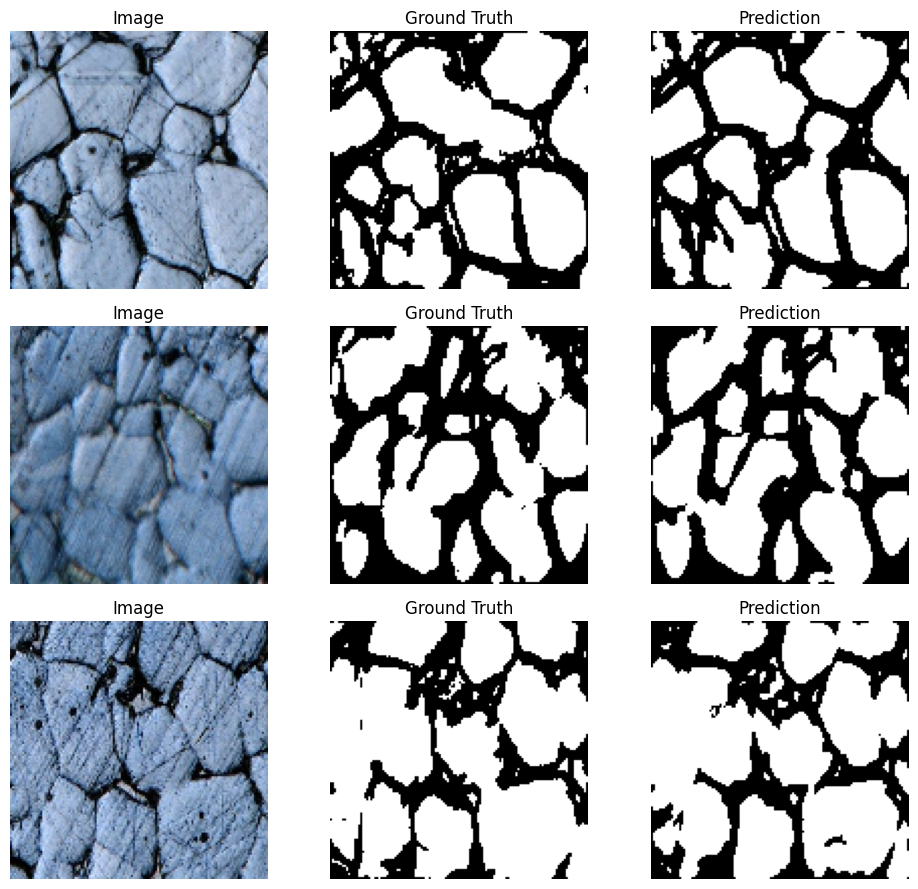

In [26]:
def plot_example(data_loader, model, device, num_examples=3):
    model.eval()  # Set model to evaluation mode
    images, masks = next(iter(data_loader))  # Get a batch of images and masks from the data loader
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)  # Generate predictions
        outputs = torch.round(outputs)  # Convert probabilities to binary values

    images = images.cpu().numpy()  # Convert tensors to numpy arrays for plotting
    masks = masks.cpu().numpy()
    outputs = outputs.cpu().numpy()

    # Plotting
    fig, axs = plt.subplots(num_examples, 3, figsize=(10, num_examples*3))
    for i in range(num_examples):
        img = np.transpose(images[i], (1, 2, 0))  # Convert from CHW to HWC format for matplotlib
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for displaying
        mask = masks[i].squeeze()  # Remove channel dimension from mask
        output = outputs[i].squeeze()  # Remove channel dimension from output

        if num_examples == 1:
            axs[0].imshow(img)
            axs[0].set_title("Image")
            axs[0].axis('off')

            axs[1].imshow(mask, cmap='gray')
            axs[1].set_title("Ground Truth")
            axs[1].axis('off')

            axs[2].imshow(output, cmap='gray')
            axs[2].set_title("Prediction")
            axs[2].axis('off')
        else:
            axs[i, 0].imshow(img)
            axs[i, 0].set_title("Image")
            axs[i, 0].axis('off')

            axs[i, 1].imshow(mask, cmap='gray')
            axs[i, 1].set_title("Ground Truth")
            axs[i, 1].axis('off')

            axs[i, 2].imshow(output, cmap='gray')
            axs[i, 2].set_title("Prediction")
            axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot the examples
plot_example(val_loader, model, device, num_examples=3)
